# Analytic spiral

We create a Magritte model from an analytic description of an Archimedean spiral outflow.
The description of the model is based on [Homan et al. (2015)](https://www.aanda.org/articles/aa/full_html/2015/07/aa25933-15/aa25933-15.html).

## Setup

Import the required functionalty.

In [1]:
import magrittetorch.model.model as magritte
import magrittetorch.tools.mesher as mesher 
import magrittetorch.tools.setup as setup
import numpy             as np                      # Data structures
from astropy import units, constants    # Unit conversions
from astropy.units import Quantity # For function arguments
import os
import torch
import warnings                                     # Hide warnings
warnings.filterwarnings('ignore')                   # especially for yt
import yt                                           # 3D plotting
import os

from tqdm                import tqdm                # Progress bars
from astropy             import units, constants    # Unit conversions
from scipy.spatial       import Delaunay, cKDTree   # Finding neighbors
from yt.funcs            import mylog               # To avoid yt output 
mylog.setLevel(40)                                  # as error messages

Define a working directory (you will have to change this; it must be an **absolute path**).

In [2]:
wdir = "/lhome/thomasc/Magrittetorch-examples/Analytic_spiral/"

Create the working directory.

In [3]:
!mkdir -p $wdir

Define file names.

In [4]:
model_file = os.path.join(wdir, 'model_analytic_spiral.hdf5')   # Resulting Magritte model
lamda_file = os.path.join(wdir, 'co.txt'                    )   # Line data file

We use a data file that can be downloaded with the following links.

In [5]:
lamda_link = "https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat"

Dowload the snapshot and the linedata (``%%capture`` is just used to suppress the output).

In [6]:
%%capture
!wget $lamda_link --output-document $lamda_file

## Spiral parameters

The functions below describe the spiral structure, based on the parameters in [Homan et al. (2015)](https://www.aanda.org/articles/aa/full_html/2015/07/aa25933-15/aa25933-15.html).

In [7]:
phi_0 =   0 / 180.0 * np.pi * units.rad
alpha =  15 / 180.0 * np.pi * units.rad
sigma =  20               * constants.au
b     = 270 / (2.0*np.pi) * constants.au


def r_0(r: Quantity[units.m], theta: Quantity[units.rad], phi: Quantity[units.rad]) -> Quantity[units.m]:
    return b*(phi - phi_0)/units.rad


def sigma_r(r: Quantity[units.m], theta: Quantity[units.rad], phi: Quantity[units.rad]) -> Quantity[units.m]:
    return sigma


def theta_0(r: Quantity[units.m], theta: Quantity[units.rad], phi: Quantity[units.rad]) -> Quantity[units.rad]:
    return 0.5*np.pi * units.rad


def sigma_theta(r: Quantity[units.m], theta: Quantity[units.rad], phi: Quantity[units.rad]) -> Quantity[units.rad]:
    return alpha


def S(r: Quantity[units.m], theta: Quantity[units.rad], phi: Quantity[units.rad]) -> Quantity[units.dimensionless_unscaled]:
    """
    Spiral-shaped distribution function.
    """
    rd = (r     - r_0    (r,theta,phi)) / sigma_r    (r,theta,phi)
    td = (theta - theta_0(r,theta,phi)) / sigma_theta(r,theta,phi)
    return np.exp(-0.5*(rd**2 + td**2))


def SS(r: Quantity[units.m], theta: Quantity[units.rad], phi: Quantity[units.rad]) -> Quantity[units.dimensionless_unscaled]:
    """
    Spiral-shaped distribution function.
    (Including 10 windings.)
    """
    result = np.zeros_like(r) / units.m
    for i in range(10):
        result += S(r, theta, phi+2.0*np.pi*i*units.rad)
    return result

## Physical parameters

In [8]:
R_max   = 600.0 * constants.au
R_star  =   1.0 * constants.R_sun
v_inf   = 14.5e+3 * units.m/units.s
beta    = 0.4 * units.dimensionless_unscaled
Mdot    = 1.5e-6 * (constants.M_sun/units.year) # [kg/s]
R_0     = 2.0 * R_star # [m]
epsilon = 0.5 * units.dimensionless_unscaled
T_star  = 2330.0 * units.K
T_0     = 60.0 * units.K
rho_max = 1.0e-11 *units.kg/units.m**3


def v_r(r: Quantity[units.m]) -> Quantity[units.m/units.s]:
    """
    Beta-law velocity profile.
    """
    return v_inf * (1.0 - R_0/r)**beta


def rho_regular(r: Quantity[units.m]) -> Quantity[units.kg/units.m**3]:
    """
    Density profile assuming a regular, spherically symmetric outflow.
    """
    return Mdot / (4.0*np.pi*r**2*v_r(r))


def rho_spiral(r: Quantity[units.m], theta: Quantity[units.rad], phi: Quantity[units.rad]) -> Quantity[units.kg/units.m**3]:
    """
    Density profile assuming a spiral outflow.
    """
    return rho_max * (2.0*np.pi*b/r)**2 * SS(r, theta, phi)


def rho_wind(r: Quantity[units.m], theta: Quantity[units.rad], phi: Quantity[units.rad]) -> Quantity[units.kg/units.m**3]:
    """
    Wind density, combined regular and spiral outflow.
    """
    return rho_regular(r) + rho_spiral(r, theta, phi)


def T_regular(r: Quantity[units.m]) -> Quantity[units.K]:
    """
    Temperature profile assuming a regular, spherically symmetric outflow.
    """
    return T_star * (R_star/r)**epsilon


def T_spiral(r: Quantity[units.m], theta: Quantity[units.rad], phi: Quantity[units.rad]) -> Quantity[units.K]:
    """
    Temperature profile assuming a spiral outflow.
    """
    return T_0 * SS(r, theta, phi)


def T_wind(r: Quantity[units.m], theta: Quantity[units.rad], phi: Quantity[units.rad]) -> Quantity[units.K]:
    """
    Wind temperature, combined regular and spiral outflow.
    """
    return T_regular(r) + T_spiral(r, theta, phi)

In [9]:
def spherical(x: Quantity[units.m],y: Quantity[units.m],z: Quantity[units.m])-> tuple[Quantity[units.m],Quantity[units.rad],Quantity[units.rad]]:
    """
    Convert cartesian to spherical coordinates.
    """
    r = np.sqrt   (x**2 + y**2 + z**2)
    t = np.arccos (z/r)
    p = np.arctan2(y,x)
    return (r,t,p)

## Create background mesh (with desired mesh element sizes)

Define the desired mesh element size in a ($100 \times 100 \times 100$) cube.

In [10]:
resolution = 100

xs = np.linspace(-R_max, +R_max, resolution, endpoint=True)
ys = np.linspace(-R_max, +R_max, resolution, endpoint=True)
zs = np.linspace(-R_max, +R_max, resolution, endpoint=True)

(Xs, Ys, Zs) = np.meshgrid(xs, ys, zs)

position = np.stack((Xs.ravel(), Ys.ravel(), Zs.ravel()), axis=1)

# Compute the corresponding spherical coordinates
# Rs = np.sqrt   (Xs**2 + Ys**2 + Zs**2)
# Ts = np.arccos (Zs/Rs)
# Ps = np.arctan2(Ys,Xs)
Rs, Ts, Ps = spherical(Xs,Ys,Zs)

# Evaluate the density on the cube
rhos = rho_wind(Rs, Ts, Ps)
rhos = np.nan_to_num(rhos, nan=1.0*units.kg/units.m**3)

Now we remesh the grid using the built-in remesher

In [11]:
positions_reduced, nb_boundary = mesher.remesh_point_cloud(position, rhos.ravel(), max_depth=10, threshold= 2e-1, hullorder=4)

new interior points:  583111
number boundary points:  1538


We add a spherical inner boundary at 0.04*R_max

In [12]:
healpy_order = 5 #using healpy to determine where to place the 12*healpy_order**2 boundary points on the sphere
origin = np.array([0.0,0.0,0.0]).T #the origin of the inner boundary sphere
positions_reduced, nb_boundary = mesher.point_cloud_add_spherical_inner_boundary(positions_reduced, nb_boundary, 0.04*R_max, healpy_order=healpy_order, origin=origin)
nb_boundary = 0 #inner boundary not yet implemented in magrittetorch, thus not classifying these first n boundary points as such
print("number of points in reduced grid: ", len(positions_reduced))


number of points in reduced grid:  584918


We add a spherical outer boundary at R_max

In [13]:
healpy_order = 15 #using healpy to determine where to place the 12*healpy_order**2 boundary points on the sphere
origin = np.array([0.0,0.0,0.0]).T #the origin of the outer boundary sphere
positions_reduced, nb_boundary = mesher.point_cloud_add_spherical_outer_boundary(positions_reduced, nb_boundary, R_max, healpy_order=healpy_order, origin=origin)
print("number of points in reduced grid: ", len(positions_reduced))

number of points in reduced grid:  290761


In [14]:
npoints = len(positions_reduced)

XCO   = 6.0e-4 * units.dimensionless_unscaled # [.]
vturb = 1.5e+3 * units.m/units.s # [m/s]


def density(rr: Quantity[units.m]) -> Quantity[units.kg/units.m**3]:
    """
    Density function.
    """
    (r, t, p) = spherical(rr[:, 0], rr[:, 1], rr[:, 2])
    r[r < R_0] = R_0 #density not defined inside the star
    return rho_wind(r, t, p)


def abn_nH2(rr: Quantity[units.m]) -> Quantity[units.m**-3]:
    """
    H2 number density function.
    """
    return density(rr) / (2.01588 * constants.u)


def abn_nCO(rr: Quantity[units.m]) -> Quantity[units.m**-3]:
    """
    CO number density function.
    """
    return XCO * abn_nH2(rr)


def temp(rr: Quantity[units.m]) -> Quantity[units.K]:
    """
    Temperature function.
    """
    (r, t, p) = spherical(rr[:, 0], rr[:, 1], rr[:, 2])
    r[r < R_0] = R_0 #temperature not defined inside the star
    return T_wind(r, t, p)


def velo(rr: Quantity[units.m]) -> Quantity[units.m/units.s]:
    """
    Velocity function.
    """
    (r, t, p) = spherical(rr[:, 0], rr[:, 1], rr[:, 2])
    r[r < R_0] = R_0 #velocity not defined inside the star
    return v_r(r)[:, None] * rr / r[:, None]



# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(positions_reduced)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Convenience arrays
zeros = np.zeros(npoints)
ones  = np.ones (npoints)

Convert model functions to arrays based the model mesh.

In [15]:
position = positions_reduced
velocity = velo(positions_reduced)
nH2      = abn_nH2(positions_reduced)
nCO      = abn_nCO(positions_reduced)
tmp      = temp(positions_reduced)
trb      = vturb * ones

## Create model

Now all data is read, we can use it to construct a Magritte model.

<div class="alert alert-warning">

Warning

Since we do not aim to do self-consistent non-LTE simulations in these examples, we only consider the first radiative transition of CO (J=1-0). To consider all transitions, use `setup.set_linedata_from_LAMDA_file` as in the commented line below it.

</div>

In [16]:
from magrittetorch.model.geometry.geometry import GeometryType
from magrittetorch.model.geometry.boundary import BoundaryType

model = magritte.Model(model_file) # Create model object
model.geometry.geometryType.set(GeometryType.General3D) # This is a 3D model
model.geometry.boundary.boundaryType.set(BoundaryType.Sphere3D) # With a spherical boundary

# In order to make unit conversions trivial, we use astropy quantities as input
model.geometry.points.position.set_astropy(position) # Set point positions
model.geometry.points.velocity.set_astropy(velocity) # Set point velocities
model.chemistry.species.abundance.set_astropy(np.stack([nCO, nH2, zeros/units.m**3], axis=1))# Set species number densities
model.chemistry.species.symbol.set(np.array(['CO', 'H2', 'e-'], dtype='S')) #Set species symbols; should correspond to the LAMDA file format
#Note: the dtype='S' is necessary to correctly save and read the species symbols to/from the hdf5 file

model.thermodynamics.temperature.gas.set_astropy(tmp) # Set gas temperature
model.thermodynamics.turbulence.vturb.set_astropy(trb) # Set turbulence velocity

model = setup.set_Delaunay_neighbor_lists (model) # Automatically computes and sets neighbors for each point, using a Delaunay triangulation
# For unitless quantities, we can also directly set the torch tensors
boundary_indices = torch.arange(nb_boundary, dtype = torch.int64)
model.geometry.boundary.boundary2point.set(boundary_indices) # Set which points are boundary points
# Conveniently, the remeshing function puts the boundary points in front of the positions array
model = setup.set_boundary_condition_CMB  (model) # Set CMB as boundary condition
model = setup.set_uniform_rays            (model, 12) # Number of rays for NLTE raytracing; has be of the form 12*2**n

#As this example does not do NLTE, we might as well only consider the first transition of CO
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [0]})
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model, 51) # Set number of quadrature points

model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing model to:  /lhome/thomasc/Magrittetorch-examples/Analytic_spiral/model_analytic_spiral.hdf5


## Plot model

Load the data in a `yt` unstructured mesh.

In [17]:
ds = yt.load_unstructured_mesh(
    connectivity = delaunay.simplices.astype(np.int64),
    coordinates  = delaunay.points.astype(np.float64) * 100.0, # yt expects cm not m 
    node_data    = {('connect1', 'n'): nCO[delaunay.simplices].astype(np.float64)}
)

Plot a slice through the mesh orthogonal to the z-axis and x-axis.


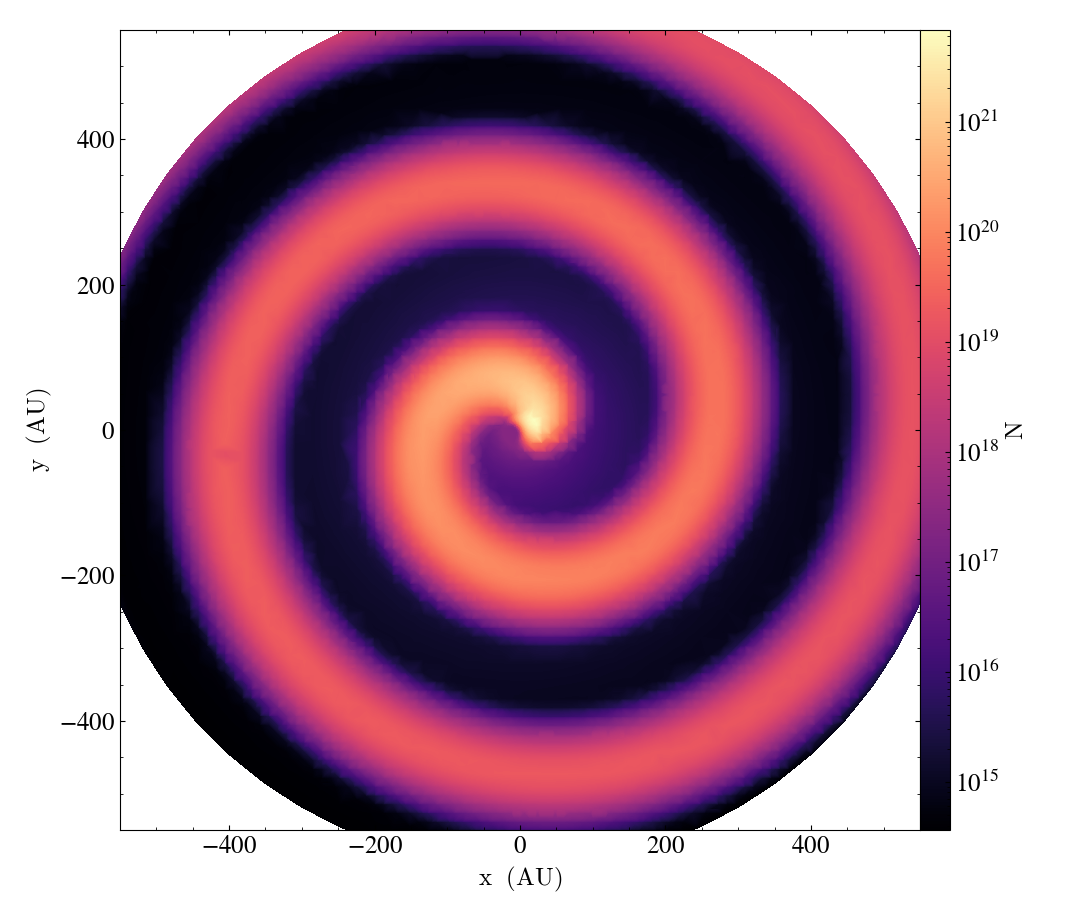

In [18]:
sl = yt.SlicePlot (ds, 'z', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.zoom           (1.2)


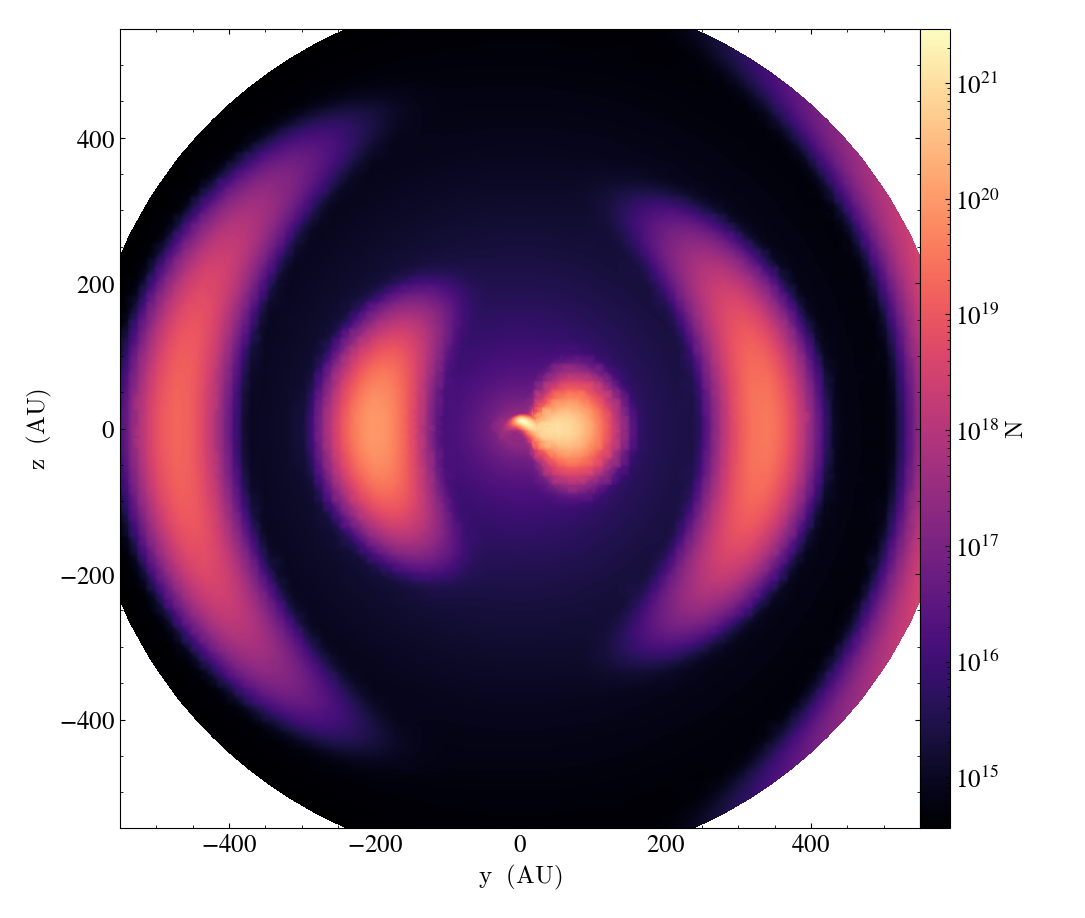

In [19]:
sl = yt.SlicePlot (ds, 'x', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.zoom           (1.2)

Show meshes on the plots.


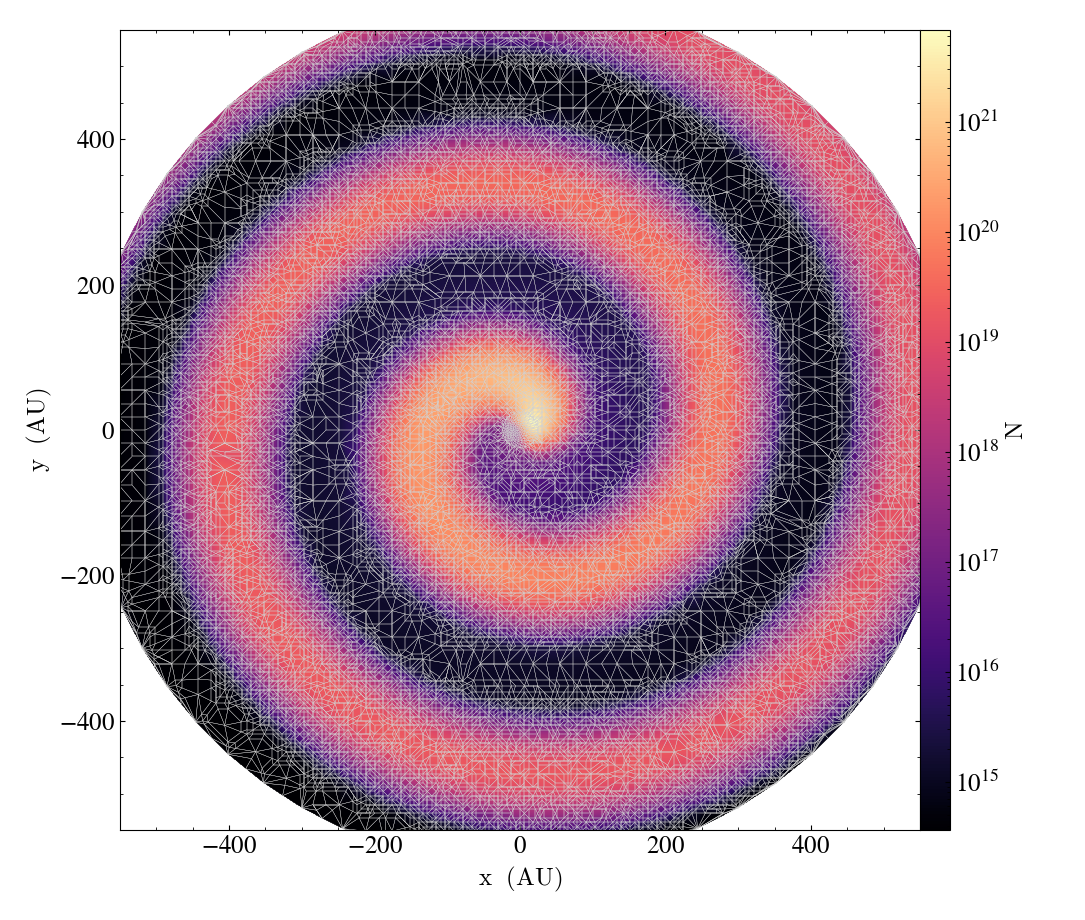

In [20]:
sl = yt.SlicePlot      (ds, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.2)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})


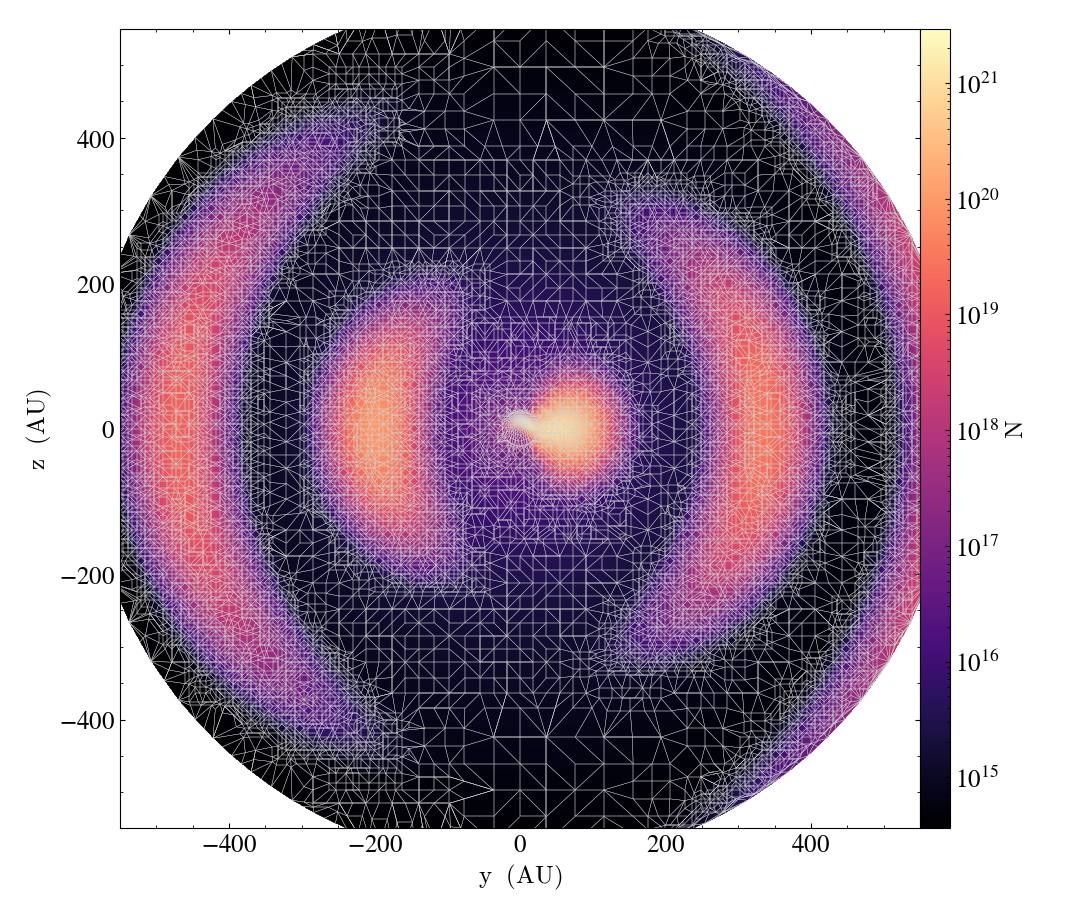

In [21]:
sl = yt.SlicePlot      (ds, 'x', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.2)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})